In [1]:
import requests
from scipy.stats import norm
import numpy as np
from datetime import datetime, timedelta,timezone
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Binance_BTCUSDT_1h.csv') #read the data
df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S", errors='coerce') #convert the date to datetime
#errors='coerce' will replace the unparsable date with NaT

period = 30 #perios of the data in days
start_date = pd.to_datetime('2022-01-01 00:00:00') #start date of the data

end_date = start_date + pd.Timedelta(days=period) #end date of the data

df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)] #filter the data based on the start and end date
df = df.sort_values(by='Date', ascending=True) #sort the data based on the date
df = df.reset_index(drop=True) #reset the index of the data

df['price'] = df['Close'] #set the price to the closing price
df['hourly_return'] = df['price'].pct_change().fillna(0.) #calculate the hourly return
#df['approx_spread'] = df['High'] - df['Low']

#df['hourly_return'] = np.log(df['price']).diff()
df

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,price,hourly_return
0,2022-01-01 00:00:00,BTCUSDT,46216.93,46731.39,46208.37,46656.13,1503.33095,6.987999e+07,38608,46656.13,0.000000
1,2022-01-01 01:00:00,BTCUSDT,46656.14,46949.99,46574.06,46778.14,943.81539,4.412715e+07,31872,46778.14,0.002615
2,2022-01-01 02:00:00,BTCUSDT,46778.14,46928.94,46721.96,46811.77,485.16860,2.272067e+07,24364,46811.77,0.000719
3,2022-01-01 03:00:00,BTCUSDT,46811.77,46916.63,46760.12,46813.20,562.88971,2.636326e+07,19882,46813.20,0.000031
4,2022-01-01 04:00:00,BTCUSDT,46813.21,46887.33,46591.23,46711.05,861.88389,4.027204e+07,23357,46711.05,-0.002182
...,...,...,...,...,...,...,...,...,...,...,...
716,2022-01-30 20:00:00,BTCUSDT,37512.37,37740.00,37351.63,37684.45,1037.92256,3.899379e+07,33851,37684.45,0.004587
717,2022-01-30 21:00:00,BTCUSDT,37684.45,37762.60,37492.25,37729.00,874.06052,3.290065e+07,26439,37729.00,0.001182
718,2022-01-30 22:00:00,BTCUSDT,37729.00,37855.54,37625.41,37785.78,734.65855,2.771975e+07,26958,37785.78,0.001505
719,2022-01-30 23:00:00,BTCUSDT,37785.78,38230.00,37778.46,37881.76,1728.81180,6.578963e+07,41359,37881.76,0.002540


Lets define a comprehensive process for calculating dynamic volatility based on various strike price ratios over time, using stock price data from df. The code also captures how the calculated volatilities evolve as the underlying spot prices and time to maturity change. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming 'df' is your DataFrame with the 'price' column already prepared

def calculate_dynamic_volatility(spot, strike, initial_spot, time_to_maturity):
    base_vol = 0.52  # Base volatility
    vol_increase_factor = 0.1  # Adjust to control the steepness of the U-shape. U-shapes are asymetrical.
    min_volatility = 0.25  # Minimum volatility
    
    # Moneyness calculation with a non-linear adjustment for a pronounced U-shape
    moneyness = abs(strike - spot) / spot #Measures how far the current spot price is from the strike price, 
    #adjusted relative to the current spot price itself.
    vol_adjustment = np.sin(vol_increase_factor * np.pi * moneyness) ** 2  # Sinusoidal adjustment for non-linearity
    #Higher and lower strike prices will have a higher volatility, while the at-the-money strike price will have the lowest volatility.
    #Non linear u-shaped function that adjusts the volatility based on the moneyness of the option.
    # Non-linear time decay factor
    # Ensuring it decreases more significantly as the option nears expiry
    time_decay = np.log(1 + time_to_maturity) / (1 + time_to_maturity) ** 2
    #Incorporates a non-linear time decay to model the decrease in volatility as the option approaches expiration.
    # Final adjusted volatility
    adjusted_volatility = base_vol + vol_adjustment - time_decay 
    #So, we try to model the volatility of the option as a function of the moneyness of the option, and the time to expiration.
    return max(adjusted_volatility, min_volatility)

initial_spot = df['price'].iloc[0]  # Initial spot price from the DataFrame
strike_ratios = [0.8, 1, 1.1, 1.2, 1.5]  # Range for demonstration

volatility_results = []

for index, row in df.iterrows(): #Iterate over the rows of the DataFrame (every hour in this case)
    #iterrows() is a generator that yields index and row data for each row in the DataFrame.
    spot = row['price'] # Current spot price
    time_to_maturity = (len(df) - index) / (365 * 24)  # Adjust based on your DataFrame
    #Calculate the time to expiration in years, based on the number of hours remaining in the DataFrame. (30 - hours passed) annualized
    for ratio in strike_ratios: #Iterate over the strike ratios
        strike = initial_spot * ratio # Calculate the strike price based on the ratio
        volatility = calculate_dynamic_volatility(spot, strike, initial_spot, time_to_maturity) 
        # Calculate the dynamic volatility, using the predefined function
        result = {
            'Hour': index,
            'Spot Price': spot,
            'Strike Price': strike,
            'Dynamic Volatility': volatility
        }
        # Store the results in a dictionary( Hour, Spot Price, Strike Price, Dynamic Volatility)
        volatility_results.append(result)

volatility_df = pd.DataFrame(volatility_results)


Plots of dynamic Volatility

Text(0.5, 1.0, 'Volatility as a function of moneyness')

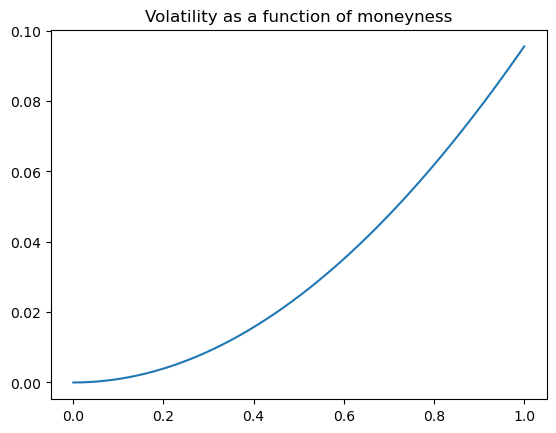

In [42]:
#Lets plot a np.sin()**2 function
x = np.linspace(0, 1, 1000)
y_1 = np.sin(0.1 * np.pi * x) ** 2
plt.plot(x, y_1)
plt.title('Volatility as a function of moneyness')



Text(0.5, 1.0, 'Volatility effect as a function of time to maturity')

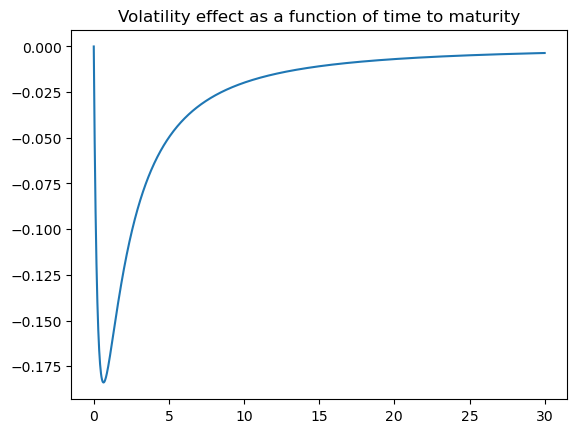

In [43]:
#Lets also plot the time decay function
x = np.linspace(0, 30, 1000)
y_2 = -np.log(1 + x) / (1 + x) ** 2
plt.plot(x, y_2)
plt.title('Volatility effect as a function of time to maturity')


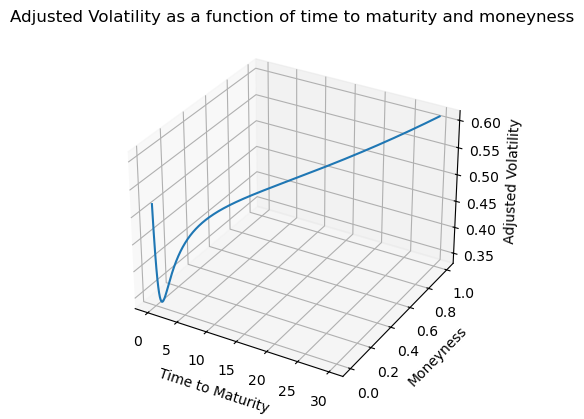

In [55]:
#finally lets plot the adjusted_volatility function
x = np.linspace(0, 30, 1000)
x2 = np.linspace(0, 1, 1000)
y = 0.52 + y_1 + y_2
#Lets change all values less than 0.52 to 0.52
y = np.where(y < 0.25, 0.25, y)
#lets do a 3d surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, x2, y)
ax.set_xlabel('Time to Maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Adjusted Volatility')
plt.title('Adjusted Volatility as a function of time to maturity and moneyness')
plt.show()


In [24]:
volatility_df.head(10)

,Hour,Spot Price,Strike Price,Dynamic Volatility,Time to Maturity
0,0,46656.13,37324.904,0.456421,0.082306
1,0,46656.13,46656.130,0.452478,0.082306
2,0,46656.13,51321.743,0.453465,0.082306
3,0,46656.13,55987.356,0.456421,0.082306
4,0,46656.13,69984.195,0.476950,0.082306
5,1,46778.14,37324.904,0.456579,0.082192
6,1,46778.14,46656.130,0.452555,0.082192
7,1,46778.14,51321.743,0.453485,0.082192
8,1,46778.14,55987.356,0.456375,0.082192
9,1,46778.14,69984.195,0.476648,0.082192


Lets visualize a 3d volatitlity surface

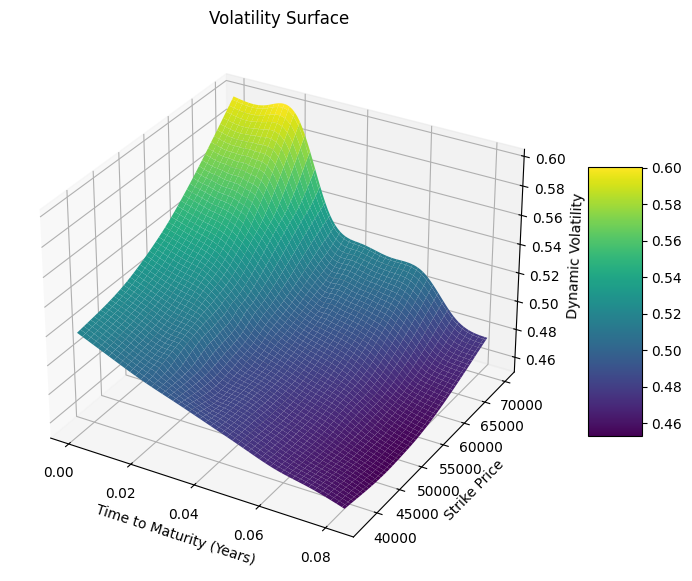

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Importing this is necessary for 3D plotting in matplotlib
from scipy.interpolate import griddata #for interpolating scattered data, for smoother surface plots

# Convert 'Hour' to 'Time to Maturity' if not already done
total_hours = len(df) # Total hours in the 30 days period
volatility_df['Time to Maturity'] = volatility_df['Hour'].apply(lambda x: (total_hours - x) / (365.0 * 24)) 
#Hours left in the 30 days period, converted to years

# Prepare data for interpolation
points = volatility_df[['Time to Maturity', 'Strike Price']].values #The x and y values
values = volatility_df['Dynamic Volatility'].values #The z values

# Create a grid to interpolate on
time_to_maturity_grid = np.linspace(volatility_df['Time to Maturity'].min(), volatility_df['Time to Maturity'].max(), 100)
strike_price_grid = np.linspace(volatility_df['Strike Price'].min(), volatility_df['Strike Price'].max(), 100)
time_grid, strike_grid = np.meshgrid(time_to_maturity_grid, strike_price_grid)

# Interpolate volatility data over the grid
volatility_grid = griddata(points, values, (time_grid, strike_grid), method='cubic')
#method='cubic' is the interpolation method, cubic interpolation is used to smooth the surface plot

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(time_grid, strike_grid, volatility_grid, cmap='viridis', edgecolor='none')

ax.set_xlabel('Time to Maturity (Years)')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Dynamic Volatility')
ax.set_title('Volatility Surface')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add a color bar which maps values to colors

plt.show()


El mismo grafico pero desde otra perspectiva

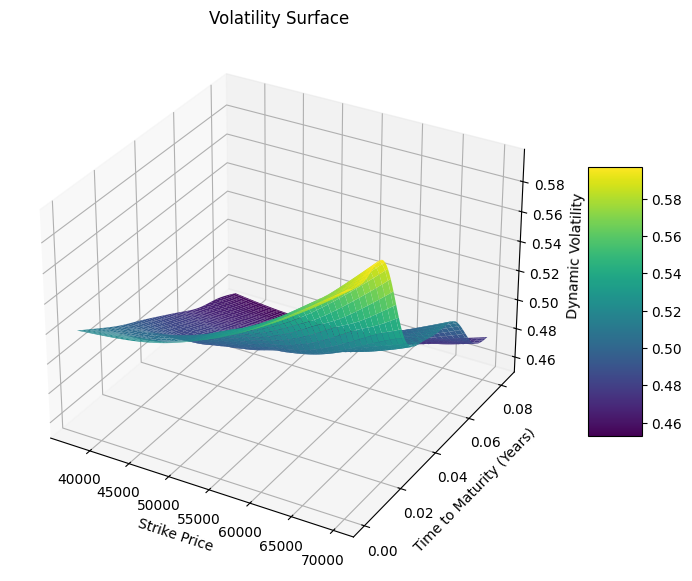

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# Convert 'Hour' to 'Time to Maturity' if not already done
total_hours = len(df)
volatility_df['Time to Maturity'] = volatility_df['Hour'].apply(lambda x: (total_hours - x) / (365.0 * 24))

# Prepare data for interpolation
points = volatility_df[['Strike Price', 'Time to Maturity']].values  # Order changed here
values = volatility_df['Dynamic Volatility'].values

# Create a grid to interpolate on
strike_price_grid = np.linspace(volatility_df['Strike Price'].min(), volatility_df['Strike Price'].max(), 100)
time_to_maturity_grid = np.linspace(volatility_df['Time to Maturity'].min(), volatility_df['Time to Maturity'].max(), 100)
strike_grid, time_grid = np.meshgrid(strike_price_grid, time_to_maturity_grid)  # Order changed here for meshgrid

# Interpolate volatility data over the grid
volatility_grid = griddata(points, values, (strike_grid, time_grid), method='cubic')

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(strike_grid, time_grid, volatility_grid, cmap='viridis', edgecolor='none')  # Order changed here for plot_surface

ax.set_xlabel('Strike Price')  # Adjusted label
ax.set_ylabel('Time to Maturity (Years)')  # Adjusted label
ax.set_zlabel('Dynamic Volatility')
ax.set_title('Volatility Surface')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Add a color bar which maps values to colors

plt.show()


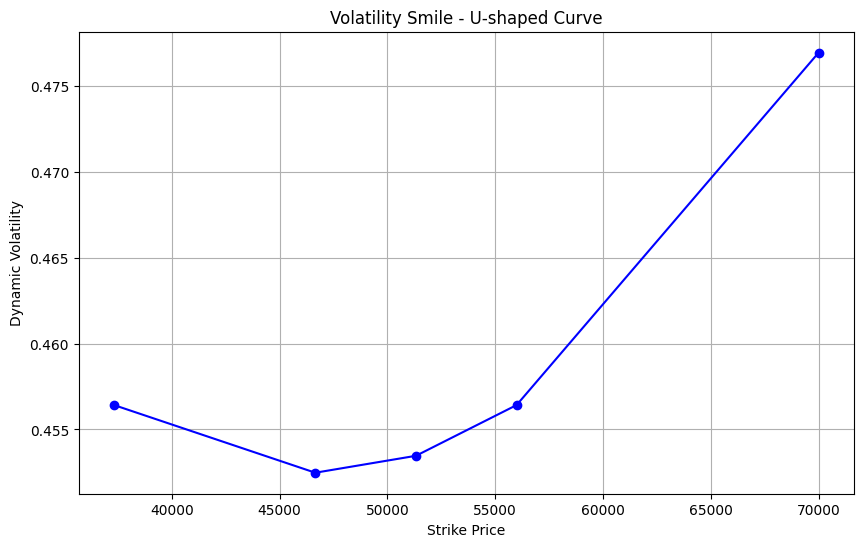

In [7]:
# Selecting a specific time to plot the volatility smile, adjust as needed
selected_time_frame = volatility_df[volatility_df['Hour'] == 0]  # For demonstration, using the first hour

# Plotting the Volatility Smile
plt.figure(figsize=(10, 6))
plt.plot(selected_time_frame['Strike Price'], selected_time_frame['Dynamic Volatility'], 'o-', color='blue')
plt.title('Volatility Smile - U-shaped Curve')
plt.xlabel('Strike Price')
plt.ylabel('Dynamic Volatility')
plt.grid(True)
plt.show()
#Los strike_ratios eran [0.8, 1, 1.1, 1.2, 1.5] por lo que el strike price es el precio de cierre multiplicado por estos ratios
#En este grafico se puede ver la sonrisa de volatilidad,
# que es una curva en forma de U que muestra como la volatilidad implícita de las opciones varía con el precio de ejercicio.

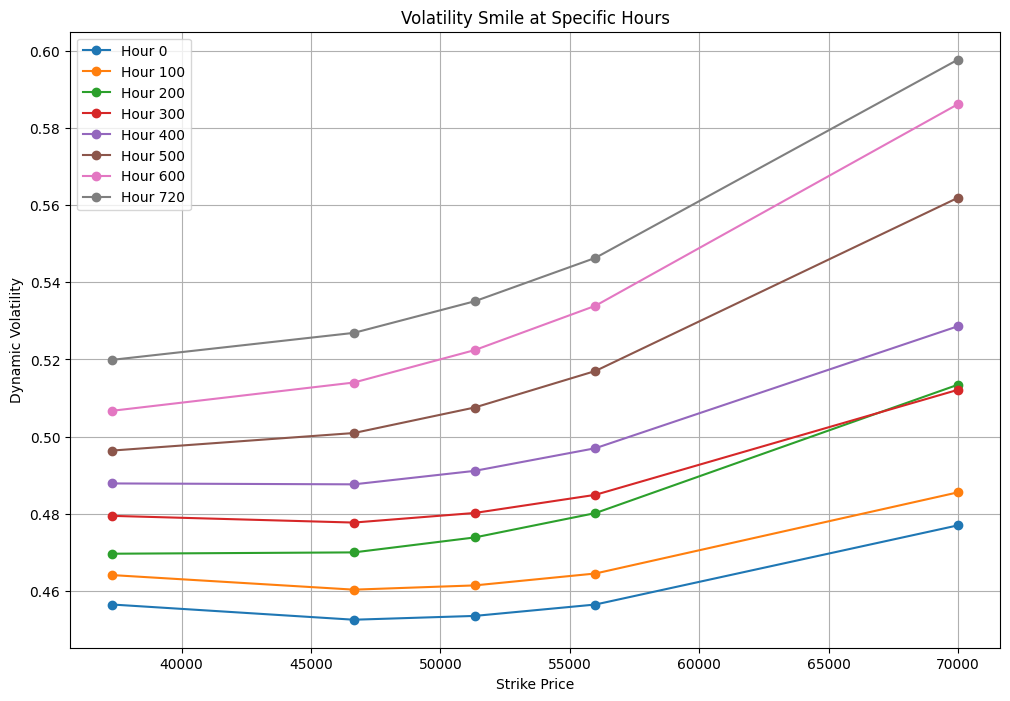

In [8]:
import matplotlib.pyplot as plt

# Specific hours you want to plot the volatility smile for
hours_to_plot = [0, 100, 200, 300, 400, 500, 600, 720]

# Set up the plot
plt.figure(figsize=(12, 8))

# Loop through each specified hour and plot the volatility smile
for hour in hours_to_plot:
    # Filter the dataframe for the specific hour
    df_at_hour = volatility_df[volatility_df['Hour'] == hour]
    
    # Check if there is data for the hour, if not, skip to the next
    if df_at_hour.empty:
        print(f"No data for hour {hour}")
        continue

    # Plotting the volatility smile for the specific hour
    plt.plot(df_at_hour['Strike Price'], df_at_hour['Dynamic Volatility'], 'o-', label=f'Hour {hour}')

# Adding plot titles and labels
plt.title('Volatility Smile at Specific Hours')
plt.xlabel('Strike Price')
plt.ylabel('Dynamic Volatility')
plt.legend()
plt.grid(True)
plt.show()
#Here, we are plotting the volatility smile at specific hours to see how the implied volatility of the options varies with the strike price at different times.
#The lower the time to maturity, the 

In [9]:
volatility_df

,Hour,Spot Price,Strike Price,Dynamic Volatility,Time to Maturity
0,0,46656.13,37324.904,0.456421,0.082306
1,0,46656.13,46656.130,0.452478,0.082306
2,0,46656.13,51321.743,0.453465,0.082306
3,0,46656.13,55987.356,0.456421,0.082306
4,0,46656.13,69984.195,0.476950,0.082306
...,...,...,...,...,...
3600,720,36829.30,37324.904,0.519904,0.000114
3601,720,36829.30,46656.130,0.526896,0.000114
3602,720,36829.30,51321.743,0.535091,0.000114
3603,720,36829.30,55987.356,0.546355,0.000114


In [10]:
import numpy as np
from scipy.stats import norm

def black_scholes_call_delta(spot, strike, time_to_maturity, risk_free_rate, volatility):
    """Calculate the Black-Scholes delta of a call option."""
    if spot == 0 or time_to_maturity <= 0:  # Avoid divide by zero
        return 0
    d1 = (np.log(spot / strike) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    return norm.cdf(d1)

# Constants
risk_free_rate = 0.01
time_to_maturity = period / 365# Assuming 'period' is defined elsewhere

strike = df['price'].iloc[0] * 1.1  # Assuming 'df' contains spot prices

# Initial setup
buffer = 0
delta_underlying = 0
hedge_position = -1
option_delta = np.array([])
delta_adjustment = np.array([])

# Transaction cost setup
transaction_cost_bps = 10
transaction_cost = transaction_cost_bps / 10000

# Iterate through each hour, using dynamic volatility
for hour in range(len(df)):
    spot = df['price'].iloc[hour]
    # Fetch dynamic volatility for the current hour
    volatility = volatility_df['Dynamic Volatility'].iloc[hour]
    
    # Calculate delta with dynamic volatility
    delta = black_scholes_call_delta(spot, strike, time_to_maturity, risk_free_rate, volatility)
    option_delta = np.append(option_delta, delta)

    # Calculate the position delta and the difference from the current underlying delta
    spot_delta = delta * hedge_position
    delta_diff = abs(spot_delta - delta_underlying)
    
    adjustment = 0  # Ensure adjustment is defined
    if delta_diff > buffer:
        if spot_delta > delta_underlying:
            adjustment = (spot_delta - delta_underlying) * spot * (1 + transaction_cost)
        else:
            adjustment = (delta_underlying - spot_delta) * spot * (1 - transaction_cost)
        delta_underlying += adjustment / spot
    
    # Update time to maturity for the next iteration
    time_to_maturity -= 1 / (365 * 24)
    delta_adjustment = np.append(delta_adjustment, adjustment / spot)

# Ensure the 'period' variable and both 'df' and 'volatility_df' dataframes are correctly set up before using this code.


In [11]:
period

30

In [12]:
# Aggregate volatility data for plotting
# Assuming volatility_df contains 'Hour', 'Spot Price', 'Strike Price', and 'Dynamic Volatility'

# Select a specific 'Hour' as the time slice to visualize the volatility smile
# For simplicity, let's use the last hour in your dataset
last_hour = volatility_df['Hour'].max()
volatility_at_last_hour = volatility_df[volatility_df['Hour'] == last_hour]

# Sorting by Strike Price for a coherent plot
volatility_at_last_hour_sorted = volatility_at_last_hour.sort_values(by='Strike Price')


In [13]:
df.head(100)

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,price,hourly_return
0,2022-01-01 00:00:00,BTCUSDT,46216.93,46731.39,46208.37,46656.13,1503.33095,6.987999e+07,38608,46656.13,0.000000
1,2022-01-01 01:00:00,BTCUSDT,46656.14,46949.99,46574.06,46778.14,943.81539,4.412715e+07,31872,46778.14,0.002615
2,2022-01-01 02:00:00,BTCUSDT,46778.14,46928.94,46721.96,46811.77,485.16860,2.272067e+07,24364,46811.77,0.000719
3,2022-01-01 03:00:00,BTCUSDT,46811.77,46916.63,46760.12,46813.20,562.88971,2.636326e+07,19882,46813.20,0.000031
4,2022-01-01 04:00:00,BTCUSDT,46813.21,46887.33,46591.23,46711.05,861.88389,4.027204e+07,23357,46711.05,-0.002182
...,...,...,...,...,...,...,...,...,...,...,...
95,2022-01-04 23:00:00,BTCUSDT,46159.91,46159.91,45760.05,45832.01,1048.25305,4.816114e+07,35669,45832.01,-0.007104
96,2022-01-05 00:00:00,BTCUSDT,45832.01,46298.56,45722.21,46271.57,1006.79621,4.635931e+07,36432,46271.57,0.009591
97,2022-01-05 01:00:00,BTCUSDT,46271.56,46333.22,46111.50,46111.50,726.20925,3.357339e+07,26849,46111.50,-0.003459
98,2022-01-05 02:00:00,BTCUSDT,46111.50,46390.15,46111.50,46296.95,639.23432,2.958300e+07,24714,46296.95,0.004022


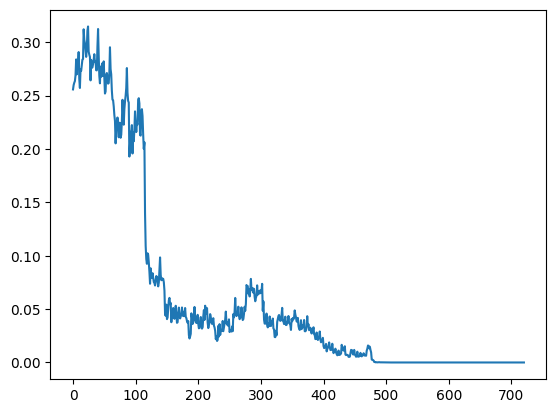

In [14]:
plt.plot(option_delta)
plt.show()

In [15]:
df['option_delta'] = option_delta

df['spot_delta'] = delta_adjustment.cumsum()
df['net_delta'] = df['spot_delta'] + df['option_delta']
df['adjustment'] = delta_adjustment
df['action'] = np.where(df['adjustment'] < 0, 'sell', np.where(df['adjustment'] > 0, 'buy', 'hold'))

# Since we're removing the bid-offer spread, adjust transaction costs directly without adjusting for bid-offer spread
df['adjusted_price'] = df['price']  # Without considering the approximated bid-offer spread

# Now, recalculate the spot return considering the adjusted price for transactions
df['spot_return'] = df['spot_delta'].shift(1) * df['adjusted_price'].shift(1) * df['hourly_return']

# Update transaction costs based on the action. Since there's no bid-offer spread, we don't adjust the price for transaction costs here
df['transaction_costs'] = np.where(df['action'] != 'hold', 
                                   abs(df['adjustment']) * df['adjusted_price'] * transaction_cost, 
                                   0)  # No transaction cost for holds

# Recalculate the net spot return by subtracting transaction costs from the spot return
df['net_spot_return'] = df['spot_return'] - df['transaction_costs']

# Recalculate the cumulative return using the net returns
df['cum_return'] = df['net_spot_return'].cumsum()


In [16]:
import pandas as pd
import numpy as np


# Your initial setup code here

# Improved handling of the delta and hedging strategy
def update_delta_and_hedge(df, transaction_cost):
    df['option_delta'] = option_delta  # Assuming option_delta is calculated elsewhere
    
    # Initialize columns if they don't exist
    if 'spot_delta' not in df:
        df['spot_delta'] = 0.0
    if 'net_delta' not in df:
        df['net_delta'] = 0.0
    if 'adjustment' not in df:
        df['adjustment'] = 0.0
    
    # Iterate through the DataFrame to update deltas and adjustments
    for i in range(1, len(df)):
        # Calculate the required adjustment for the current row
        required_adjustment = -df.loc[i-1, 'net_delta']  # Aim to neutralize the previous net delta
        df.loc[i, 'adjustment'] = required_adjustment
        
        # Update the spot delta based on the adjustment
        df.loc[i, 'spot_delta'] = df.loc[i-1, 'spot_delta'] + required_adjustment
        
        # Update the net delta for the current row
        df.loc[i, 'net_delta'] = df.loc[i, 'spot_delta'] + df.loc[i, 'option_delta']
    
    # Define actions based on adjustments
    df['action'] = np.where(df['adjustment'] < 0, 'sell', np.where(df['adjustment'] > 0, 'buy', 'hold'))
    
    # Assuming 'adjusted_price' and 'price' are already correctly set
    df['adjusted_price'] = df['price']  # Assuming this is correct for your case
    
    # Transaction cost adjustments
    df['transaction_costs'] = np.where(df['action'] != 'hold', abs(df['adjustment']) * df['adjusted_price'] * transaction_cost, 0)
    
    # Spot return calculations, assuming hourly returns are calculated elsewhere
    df['spot_return'] = df['spot_delta'].shift(1) * df['adjusted_price'].diff()  # Using price difference for returns
    
    # Net spot return after transaction costs
    df['net_spot_return'] = df['spot_return'] - df['transaction_costs']
    
    # Cumulative return
    df['cum_return'] = df['net_spot_return'].cumsum()
    
    return df

# Assuming transaction_cost is defined
# Update the DataFrame
df = update_delta_and_hedge(df, transaction_cost)

# Make sure to replace the placeholders and assumptions with your actual variables and logic.


In [17]:
df

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount,price,...,option_delta,spot_delta,net_delta,adjustment,action,adjusted_price,spot_return,transaction_costs,net_spot_return,cum_return
0,2022-01-01 00:00:00,BTCUSDT,46216.93,46731.39,46208.37,46656.13,1503.33095,6.987999e+07,38608,46656.13,...,2.556949e-01,2.554392e-01,5.111341e-01,2.554392e-01,buy,46656.13,NaN,1.191780e+01,NaN,NaN
1,2022-01-01 01:00:00,BTCUSDT,46656.14,46949.99,46574.06,46778.14,943.81539,4.412715e+07,31872,46778.14,...,2.598053e-01,-2.556949e-01,4.110454e-03,-5.111341e-01,sell,46778.14,3.116614e+01,2.390990e+01,7.256234e+00,7.256234
2,2022-01-01 02:00:00,BTCUSDT,46778.14,46928.94,46721.96,46811.77,485.16860,2.272067e+07,24364,46811.77,...,2.619736e-01,-2.598053e-01,2.168243e-03,-4.110454e-03,sell,46811.77,-8.599019e+00,1.924176e-01,-8.791437e+00,-1.535202
3,2022-01-01 03:00:00,BTCUSDT,46811.77,46916.63,46760.12,46813.20,562.88971,2.636326e+07,19882,46813.20,...,2.634946e-01,-2.619736e-01,1.521052e-03,-2.168243e-03,sell,46813.20,-3.715216e-01,1.015024e-01,-4.730240e-01,-2.008226
4,2022-01-01 04:00:00,BTCUSDT,46813.21,46887.33,46591.23,46711.05,861.88389,4.027204e+07,23357,46711.05,...,2.688895e-01,-2.634946e-01,5.394845e-03,-1.521052e-03,sell,46711.05,2.676060e+01,7.104995e-02,2.668955e+01,24.681326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2022-01-30 20:00:00,BTCUSDT,37512.37,37740.00,37351.63,37684.45,1037.92256,3.899379e+07,33851,37684.45,...,7.367294e-213,0.000000e+00,7.367294e-213,5.283379e-120,buy,37684.45,-9.091639e-118,1.991012e-118,-1.108265e-117,887.934647
717,2022-01-30 21:00:00,BTCUSDT,37684.45,37762.60,37492.25,37729.00,874.06052,3.290065e+07,26439,37729.00,...,2.088198e-277,-7.367294e-213,-7.367294e-213,-7.367294e-213,sell,37729.00,0.000000e+00,2.779607e-211,-2.779607e-211,887.934647
718,2022-01-30 22:00:00,BTCUSDT,37729.00,37855.54,37625.41,37785.78,734.65855,2.771975e+07,26958,37785.78,...,0.000000e+00,0.000000e+00,0.000000e+00,7.367294e-213,buy,37785.78,-4.183150e-211,2.783790e-211,-6.966939e-211,887.934647
719,2022-01-30 23:00:00,BTCUSDT,37785.78,38230.00,37778.46,37881.76,1728.81180,6.578963e+07,41359,37881.76,...,0.000000e+00,0.000000e+00,0.000000e+00,-0.000000e+00,hold,37881.76,0.000000e+00,0.000000e+00,0.000000e+00,887.934647


<Axes: >

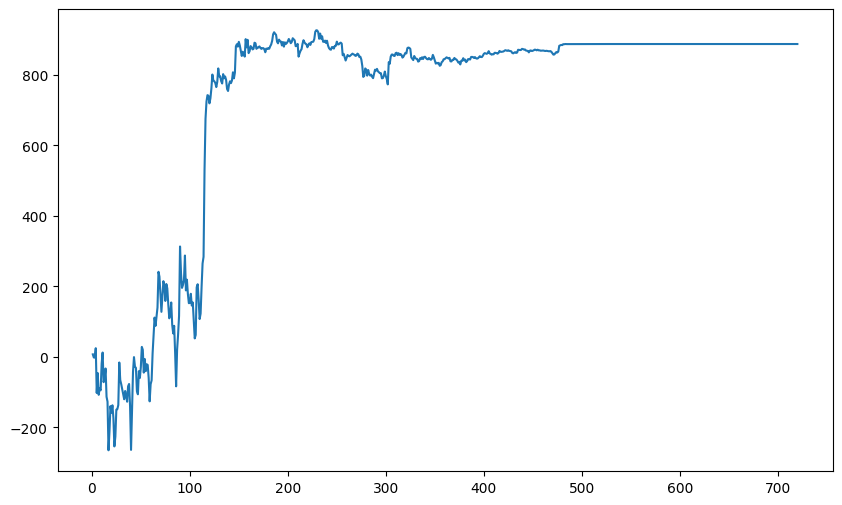

In [18]:
# Calculate the cumulative returns
plt.figure(figsize=(10,6))

df['cum_return'].plot()

In [19]:
#option payoff
end_price = df['price'].iloc[-1]
option_payoff = max(0, end_price - strike*(1+risk_free_rate)**(-period/365))

option_payoff

0

In [20]:
total_money_return = option_payoff + df['cum_return'].iloc[-1]
total_money_return

887.9346474780956

In [21]:
# Scenario A
open_price = df['price'].iloc[0]
open_spot = 1 * open_price
call_premium =0.02 * open_spot

if end_price > strike:
    money_return = call_premium + strike * 1
else:
    money_return = call_premium

money_return

933.1225999999999

In [22]:
 import numpy as np
from scipy.stats import norm

def black_scholes_call(S0, X, T, r, sigma):
    """
    Calculate the Black-Scholes call option price using dynamic volatility.
    
    Parameters:
    - S0: current price of the stock (underlying asset).
    - X: strike price of the option.
    - T: time to maturity of the option (in years).
    - r: risk-free interest rate.
    - sigma: volatility of the stock's returns (dynamic for each period).
    
    Returns:
    - Call option price (premium).
    """
    d1 = (np.log(S0 / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S0 * norm.cdf(d1)) - (X * np.exp(-r * T) * norm.cdf(d2))
    return call_price

# Assuming 'df' contains the spot prices and 'volatility_df' contains the dynamic volatility
# Let's calculate the call option price for the first entry as an example
current_price = df['price'].iloc[0]  # Current stock price
strike_price = current_price * 1.1  # Strike price (10% above current price)
time_to_maturity = 1/ 365*24 # Time to maturity in years, assuming very short period
risk_free_rate = 0.01  # Annual risk-free interest rate

# Fetch dynamic volatility for the current period from 'volatility_df'
# Assuming we want the volatility for the first hour as an example
dynamic_volatility = 0.52#volatility_df['Dynamic Volatility'].iloc[0]

# Calculate the call option price using the dynamic volatility
call_option_price = black_scholes_call(current_price, strike_price, time_to_maturity, risk_free_rate, dynamic_volatility)

print(f"Call Option Price: {call_option_price:.2f}")


Call Option Price: 915.34
